In [1]:
import pickle
from os.path import join
import matplotlib.pyplot as plt
from glob import glob
import numpy as np
import pandas as pd

In [2]:
result_dir = '/bsuscratch/zacharykeskinen/data/infrasound/wind_results'
tmp_dir = join(result_dir,'tmp')
res = pd.DataFrame()
for f in glob(join(tmp_dir, '*')):
    with open(f, 'rb') as f:
        df = pickle.load(f)
    res = pd.concat([res, df])

with open(join(result_dir, 'windv2.pkl'), 'wb') as f:
    pickle.dump(res, f)

In [3]:
result_dir = '/bsuscratch/zacharykeskinen/data/infrasound/wind_results'
with open(join(result_dir, 'windv2.pkl'), 'rb') as f:
    wind = pickle.load(f)

In [167]:
wind

,sd_delta,wind,power,cor,fs,powers
0,0.18,1.83,"([0.0, 0.78125, 1.5625, 2.34375, 3.125, 3.9062...",0.193194,"[0.0, 0.78125, 1.5625, 2.34375, 3.125, 3.90625...","[3.1768324615266826e-07, 1.7612371014900903e-0..."
0,-0.17,1.83,"([0.0, 0.78125, 1.5625, 2.34375, 3.125, 3.9062...",0.198057,"[0.0, 0.78125, 1.5625, 2.34375, 3.125, 3.90625...","[7.45017887011278e-07, 4.553649718878474e-06, ..."
0,-0.20,1.83,"([0.0, 0.78125, 1.5625, 2.34375, 3.125, 3.9062...",0.193194,"[0.0, 0.78125, 1.5625, 2.34375, 3.125, 3.90625...","[9.002660542985434e-07, 5.339784332296669e-06,..."
0,0.18,2.06,"([0.0, 0.78125, 1.5625, 2.34375, 3.125, 3.9062...",0.160276,"[0.0, 0.78125, 1.5625, 2.34375, 3.125, 3.90625...","[3.203040936327604e-07, 1.8022055803382808e-06..."
0,-0.17,2.06,"([0.0, 0.78125, 1.5625, 2.34375, 3.125, 3.9062...",0.161932,"[0.0, 0.78125, 1.5625, 2.34375, 3.125, 3.90625...","[5.749228128581775e-07, 3.489480427507343e-06,..."
...,...,...,...,...,...,...
0,0.32,3.09,"([0.0, 0.78125, 1.5625, 2.34375, 3.125, 3.9062...",0.129973,"[0.0, 0.78125, 1.5625, 2.34375, 3.125, 3.90625...","[4.1336840310571387e-07, 2.428260200434958e-06..."
0,1.32,2.74,"([0.0, 0.78125, 1.5625, 2.34375, 3.125, 3.9062...",0.071859,"[0.0, 0.78125, 1.5625, 2.34375, 3.125, 3.90625...","[3.1720939527990606e-07, 1.8831462243283038e-0..."
0,0.97,2.74,"([0.0, 0.78125, 1.5625, 2.34375, 3.125, 3.9062...",0.080168,"[0.0, 0.78125, 1.5625, 2.34375, 3.125, 3.90625...","[2.912858998767234e-07, 1.6465356202588993e-06..."
0,0.67,2.74,"([0.0, 0.78125, 1.5625, 2.34375, 3.125, 3.9062...",0.096378,"[0.0, 0.78125, 1.5625, 2.34375, 3.125, 3.90625...","[2.860435516012249e-07, 1.6492077818078509e-06..."


In [4]:
wind[['fs','powers']] = pd.DataFrame(wind['power'].tolist(), index=wind.index)
wind = wind.loc[wind.cor < wind.cor.quantile(0.8)]
# wind = wind.loc[wind.wind > 6]
# wind = wind.drop(['power'], axis = 1)
powers = pd.DataFrame(wind['powers'].tolist(), index=wind.index, columns = wind.iloc[0]['fs'])
powers[['sd_delta','cor','wind']] = wind[['sd_delta','cor','wind']]
#powers.loc[powers.sd_delta < -0.5, 'sd_delta'] = -0.5
plot = powers.drop(['cor','wind'], axis= 1).groupby('sd_delta').mean()
new_index = np.linspace(plot.index[0], plot.index[-1], len(plot))
df_resampled = plot.reindex(plot.index.union(new_index)).interpolate(method='nearest').loc[new_index]

In [119]:
levels = [[None,0],[0,0.2],[0.2,0.4],[0.4,0.6],[0.6,0.8],[0.8,1],[1,1.2],[1.2,None]]
plot = pd.DataFrame()
for low, high in levels:
    d = {}
    if low == None:
        sub = powers.loc[powers.sd_delta < high]
        low = -0.2
    elif high == None:
        sub = powers.loc[powers.sd_delta > low]
    else:
        sub = powers.loc[(powers.sd_delta > low) & (powers.sd_delta < high)]
    sub = sub.drop(['sd_delta', 'cor', 'wind'], axis = 1).dropna().mean()
    sub.index = np.round(sub.index.astype(float),2)
    d[low] = sub
    plot = pd.concat([plot, pd.DataFrame.from_dict(d)], axis = 1)

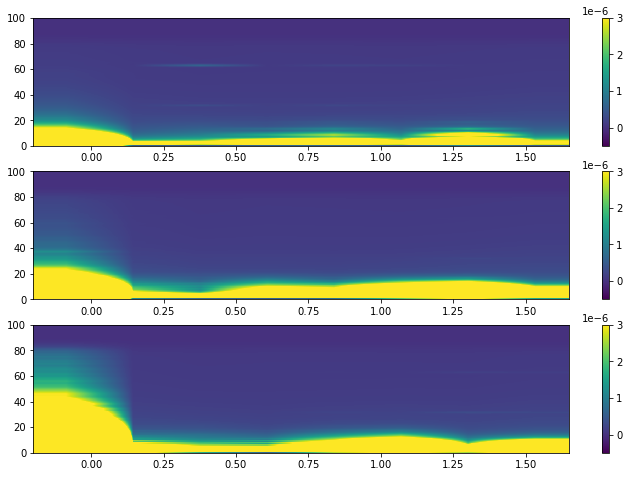

In [166]:
from re import A


f, axes = plt.subplots(3, figsize= (12,8))
levels = [[None,0],[0,0.2],[0.2,0.4],[0.4,0.6],[0.6,0.8],[0.8,1],[1,1.2],[1.2,None]]

for i, (low, high) in enumerate([[0,3],[3,5],[5,10]]):
    ax = axes[i]
    power_sub = powers.loc[(powers.wind < high) & (powers.wind > low)]
    plot = pd.DataFrame()
    for low, high in levels:
        d = {}
        if low == None:
            sub = power_sub.loc[power_sub.sd_delta < high]
            low = -0.2
        elif high == None:
            sub = power_sub.loc[power_sub.sd_delta > low]
        else:
            sub = power_sub.loc[(power_sub.sd_delta > low) & (power_sub.sd_delta < high)]
        sub = sub.drop(['sd_delta', 'cor', 'wind'], axis = 1).dropna().mean()
        sub.index = np.round(sub.index.astype(float),2)
        d[low] = sub
        plot = pd.concat([plot, pd.DataFrame.from_dict(d)], axis = 1)
    im = ax.imshow(plot[::-1], aspect = 'auto',vmin=-0.0000005, vmax=0.000003, interpolation = 'bilinear',extent = (df_resampled.index[0], df_resampled.index[-1], df_resampled.columns[0], df_resampled.columns[-1]))
    plt.colorbar(im, ax= ax)

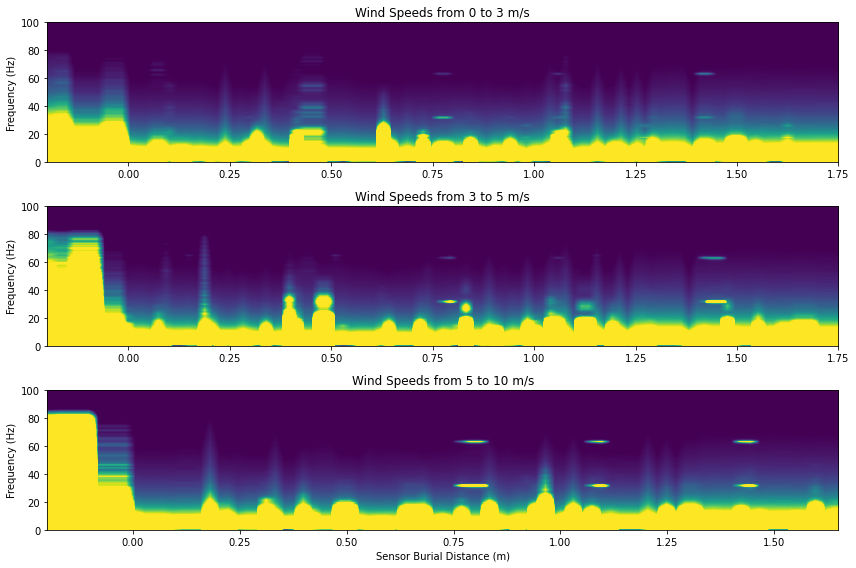

In [111]:
from matplotlib.colors import LogNorm
f, axes = plt.subplots(3, figsize= (12,8))
# norm=LogNorm(vmin=0.00000007, vmax=0.000001)
# vmax = 0.0000009
for i, (low, high) in enumerate([[0,3],[3,5],[5,10]]):
    ax = axes[i]
    with open(join(result_dir, 'windv2.pkl'), 'rb') as f:
        wind = pickle.load(f)
    wind[['fs','powers']] = pd.DataFrame(wind['power'].tolist(), index=wind.index)
    # wind = wind.loc[wind.cor < wind.cor.quantile(0.5)]
    wind.loc[wind.sd_delta < -0.2, 'sd_delta'] = -0.2
    powers = pd.DataFrame(wind['powers'].tolist(), index=wind.index, columns = wind.iloc[0]['fs'])
    powers[['sd_delta','cor','wind']] = wind[['sd_delta','cor','wind']]

    plot = powers.loc[(powers.wind < high) & (powers.wind > low)].drop(['cor','wind'], axis= 1).groupby('sd_delta').mean()
    new_index = np.linspace(plot.index[0], plot.index[-1], len(plot))
    df_resampled = plot.reindex(plot.index.union(new_index)).interpolate(method='nearest').loc[new_index]
    ax.imshow(df_resampled.T.iloc[::-1],vmin=0.0000001, vmax=0.0000005, extent = (df_resampled.index[0], df_resampled.index[-1], df_resampled.columns[0], df_resampled.columns[-1]), aspect = 'auto', interpolation = 'bilinear')
    ax.set_ylabel('Frequency (Hz)')
    ax.set_title(f'Wind Speeds from {low} to {high} m/s')
axes[2].set_xlabel('Sensor Burial Distance (m)')
#plt.xlim(-0.2,0.5)
plt.tight_layout()